# Purpose:

My testing of the sciAnalysis with recombination map of D melanogaster has proved to be mostly fruitless. There are some rather large problems with correctly clustering individuals. There seems to be a large amount of incorrect clustering, especially in E0s. This causes issues when I try to infer the strength of the segregation distortion. I think a way to get around this would be to use a system with a higher recombination rate. With higher recombination there would be more crossovers in a given cross and it would be easier to individuate the cells. 

A system to do this in would be D. virillis, they have about a 2x higher rate of recombination than Melanogaster. But before I go about and simulate Virillis data I am going to simply double the size of the recombination map in Drosophila to see if the recombination rate will truly solve my issues. To increase the recombination rate I'm simply going to double the genetic distance in the Melanogaster map.

In [23]:
import csv
import pandas as pd
import numpy as np
import os
import numpy as np
import operator
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
from sklearn.cluster import AgglomerativeClustering
import argparse
from multiprocessing import Pool
import random
from scipy.optimize import curve_fit
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
import sys
sys.path.insert(1, '/home/iskander/Documents/Barbash_lab/mDrive/')
from sciAnalysis import *

def extrStates(states):
    #I am attempting to conform the reading of these known labels to the way that I have produced the HMM labels
    #within sciAnalysis so I can re-use code....
    state_tuples = []
    if len(states) > 1:
        for s in range(len(states)-1):
            state_tuples.append((states[s], states[s+1]))
    else:
        state_tuples.append(states[0])
    
    return state_tuples

def readCO(tsv, path):
    #Record only the individuals that are unique the sampling to get the true AF
    COs = []
    labels = []
    add_Mb = {'2L': 0, '2R': 23000000, '3L': 0, '3R': 24500000, 'X': 0}
    full_tsv = os.path.join(path, tsv)
    with open(full_tsv, 'r') as myTsv:
        TSV_reader = csv.reader(myTsv, delimiter='\t')

        index = 0
        for field in TSV_reader:
            #each individual will have an array of their breakpoints and their chromosome states
            chr2 = [int(pos)/1000000 for pos in field[2].split(',') if pos != ''] + [(int(pos) + add_Mb['2R'])/1000000 for pos in field[5].split(',') if pos != '']
            chr2_states = [int(segment) for segment in field[3].split(',')][:-1] + [int(segment) for segment in field[6].split(',')]
            refChr2 = extrStates(states=chr2_states)
            
            chr3 = [int(pos)/1000000 for pos in field[8].split(',') if pos != ''] + [(int(pos) + add_Mb['3R'] )/1000000for pos in field[11].split(',') if pos != '']
            chr3_states = [int(segment) for segment in field[9].split(',')][:-1] + [int(segment) for segment in field[12].split(',')]
            refChr3 = extrStates(states= chr3_states)
            
            chrx = [int(pos)/1000000 for pos in field[14].split(',') if pos != '']
            chrx_states = [int(segment) for segment in field[15].split(',')]
            refChrx = extrStates(states=chrx_states)
            
            all_labels = [refChr2, refChr3, refChrx]
            all_COS = [chr2, chr3, chrx]
            COs.append(all_COS)
            labels.append(all_labels)
            
            index += 1
            
    return COs, labels

def sciAnalysis_methods(CO_data, state_labels):
    myAnalysis = analyzeSEQ()
    myAnalysis.polarized_samples = myAnalysis.load_SNP_array(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/',
                                                            snp_array='SIZE_TEST_NEW.npy', encoding='latin1')
    myAnalysis.paintedGenome = [np.concatenate((myAnalysis.polarized_samples[0][0][:, 0], myAnalysis.polarized_samples[0][1][:, 0] + 23000000)) / 1000000,
                                np.concatenate((myAnalysis.polarized_samples[0][2][:, 0], myAnalysis.polarized_samples[0][3][:, 0] + 24500000)) / 1000000,
                                myAnalysis.polarized_samples[0][4][:, 0] / 1000000]

    SNP_pileup = []
    for sample in range(len(state_labels)):
        
        SNPs = myAnalysis.paintChromosome(breakpoints=CO_data[sample], labels=state_labels[sample])
        SNP_pileup.append(SNPs)
    
    for arm in range(3):
        myAnalysis.paintedGenome[arm] = np.vstack((myAnalysis.paintedGenome[arm], np.sum(np.vstack(np.vstack(SNP_pileup)[:,arm]), axis=0) / (2*len(state_labels)))).T
    
    #Compute SD params
    params, errs, AFs = myAnalysis.estimateSD_params(myAnalysis.paintedGenome)
    
    
    #Do the plotting
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(12,5))
        sns.scatterplot(myAnalysis.paintedGenome[1][:,0], myAnalysis.paintedGenome[1][:,1],edgecolor=None, alpha=.1, color='black')
        plt.plot(AFs[1][:,0], AFs[1][:,1], linestyle='--', color='blue')
        plt.title('Chr3 theoretical pseudobulk')
        plt.xlabel('Mb')
        plt.ylabel('P2 AF')
        plt.show()
        plt.close()

    print('Driver strength: {0:.2f}%'.format(params[1][0]*100))
    

In [24]:
def double_map(rmap='/home/iskander/Documents/Barbash_lab/mDrive/dmel.rmap.bed'):
    with open(rmap, 'r') as myMap:
        with open('dmel_2xRate.rmap.bed', 'w') as newRMAP:
            for field in csv.reader(myMap, delimiter='\t'):
                mid = abs(float(field[2]) - float(field[3])) / 2
                for split in range(2):
                    newBin = 2*int(field[1])+split
                    if split == 0:
                        positions = [float(field[2]), float(field[2]) + mid]
                    else:
                        positions = [float(field[2]) + mid + (1/1000000), float(field[3])]
                    BED_line = "{0}\t{1}\t{2:.6f}\t{3:.6f}\n".format(field[0], newBin, positions[0], positions[1])
                    newRMAP.write(BED_line)
            newRMAP.close()
        myMap.close()


This code produces a recombination map for D melanogaster with about 2x higher recombination rate, which is more or less the rate of recombination for D virillis. 

# D mel data w/ D. virillis recombination rate (2x):

To simplify my future analyses and save me some time I am just going to analyze data that has a size distortion parameter and 2x increased recombination rate. In the future I will use the actual virillis assembly to create my simulated data, but for now this will have to do.

In [7]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_2x_rate_SIZE_TEST_HMM_posteriors.npy')
df = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/2x_rate_SIZE_TEST_crossovers.tsv', header=None, sep='\t')
true_labels = df.values[:,0]

FileNotFoundError: [Errno 2] No such file or directory: '/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_2x_rate_SIZE_TEST_HMM_posteriors.npy'

In [4]:
#ARI score for hierarchical clustering
pred_labels = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)
ARI = metrics.adjusted_rand_score(pred_labels, true_labels)
print(ARI)

NameError: name 'posteriors' is not defined

Allele frequency distribution taking only the non-duplicate samples:

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


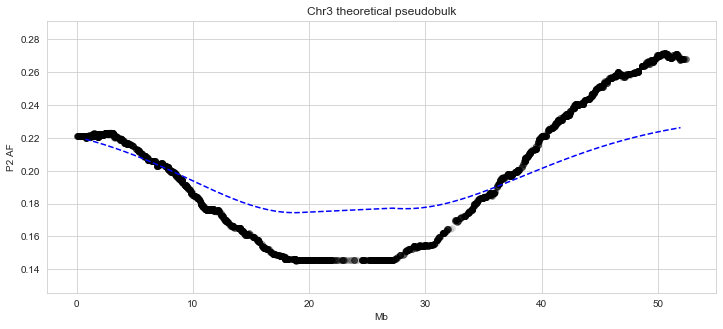

Driver strength: 15.31


In [73]:
true_distr = [i for i in range(1517)]
co, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', tsv='2x_rate_SIZE_TEST_crossovers.tsv')

called_cos = []
called_labels = []
for i in true_distr:
    called_cos.append(co[i])
    called_labels.append(labels[i])
    
sciAnalysis_methods(called_cos, called_labels)

Clearly something is very very wrong here. Because the elevation in probability of being sampled is not being cleared out of the pool by clustering. 

I think what may be happening here is that if ALL of the P1/P1 individuals have a very high bias towards being sampled then it is possible to cluster individuals very precisely, but not normalize because although the clusters are being collapsed there was such an ENORMOUS bias at the initial sampling that we cannot normalize it at all. This may be able to be reduced by increasing the number of individuals that are inputted, or the number of cells that are sequence in the pool. If I just sequence a lot more cells then number of unique individuals ends up decreasing which works in my favor in these situations. 

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


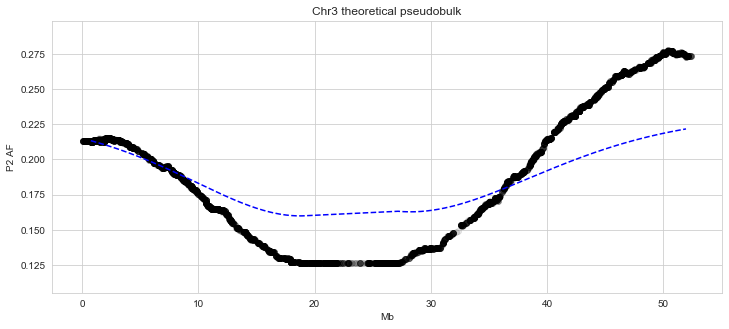

Driver strength: 18.27


In [76]:
co, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', tsv='2x_rate_SIZE_TEST_crossovers.tsv')

sciAnalysis_methods(co, labels)

#### AF of no size distortion:

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


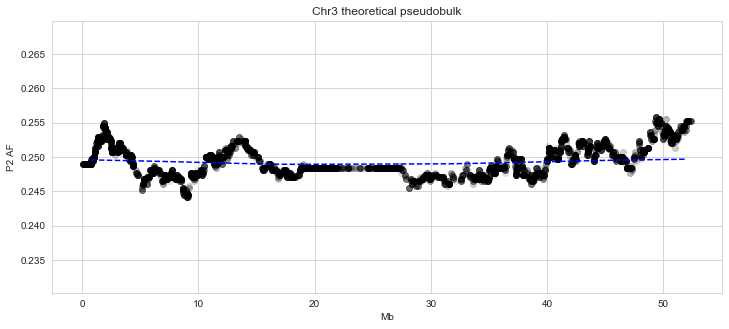

Driver strength: 0.22%


In [79]:
true_distr = [i for i in range(1536)]
co, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', tsv='2x_rate_noSIZE_crossovers.tsv')

called_cos = []
called_labels = []
for i in true_distr:
    called_cos.append(co[i])
    called_labels.append(labels[i])
    
sciAnalysis_methods(called_cos, called_labels)

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


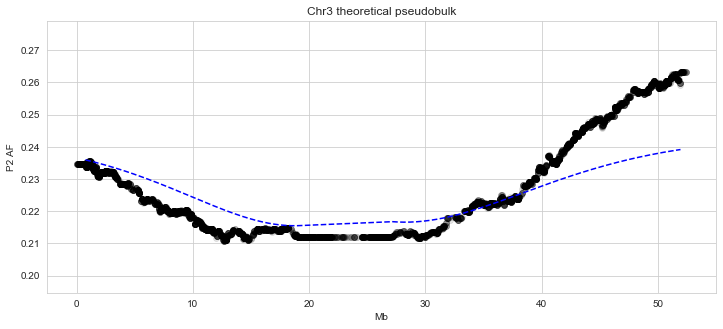

Driver strength: 7.00%


In [80]:

true_distr = [i for i in range(1752)]
co, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', tsv='2x_rate_.2xSize_crossovers.tsv')

called_cos = []
called_labels = []
for i in true_distr:
    called_cos.append(co[i])
    called_labels.append(labels[i])
    
sciAnalysis_methods(called_cos, called_labels)

In [71]:
### E0s ####


breakpoints = np.vstack((df.values[:,3], df.values[:,6], df.values[:,9], df.values[:,12], df.values[:,15]))

get_bp = lambda x: len(x.split(',')) - 1

vf = np.vectorize(get_bp)(breakpoints)
E0s = len(np.where(np.sum(vf, axis=0) == 0)[0])


The allele freq decay does not fit our data because we are using a different genetic map to calculate AF decay curves than what was used to generate the data. We simply have to load in the recombination map that was used for the simulation and find a way to cleverly map it.

In [34]:
rmap = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/dmel_2xRate.rmap.bed', sep='\t', header=None)

In [68]:
chr2L_bins = rmap.loc[rmap[0] == '2L'].values[:,1:4]
position = 15
inter = np.intersect1d( np.where(position >= chr2L_bins[:,1]),np.where(position < chr2L_bins[:,2]))
chr2L_bins[inter][0][0]

98

In [69]:
get_cM = lambda x: chr2L_bins[np.intersect1d( np.where(x >= chr2L_bins[:,1]),np.where(x < chr2L_bins[:,2]))][0][0]

In [82]:
pos_vector = [1,2,3,4,5]

list(map(get_cM, pos_vector))

[3, 9, 16, 23, 31]

## D. virillis SNP calls:

The most important parameter whether or not D. virillis would be a good system to work with is how many SNPs of difference there are between any given strains. In particular we are interested in doing comparisions of the high and low centromeric satellite strains. Julien had a number of strains sequenced at fairly low coverage like 2-3x and has been doing some rudimentary SNP analysis. I am going to do some analysis of whatever SNPs were called between the strains and see if this preliminary data will give us a good estimation. In all likelihood the number of SNPs ought to be GREATER than the number of SNPs that were calculated here. Therefore even if the number of SNPs is not great we may get better results with more sequencing.

In [2]:
#Get SNPs between vir51 and vir47 strains high and low centromere strains
NT_encoding ={'A':0, 'T':1, 'C':2, 'G':3}
chromosomes = ('Chr_2', 'Chr_3', 'Chr_4', 'Chr_5', 'Chr_6', 'Chr_X')
reference_nparray = []
scaffold_array = {}
for chrs in chromosomes:
    scaffold_array[chrs] = [] 

with open('/home/iskander/Documents/Barbash_lab/mDrive/virillis/GATK_merged.vironly.vcf.recode.vcf') as VCF:
    myVCF = csv.reader(VCF, delimiter='\t')
    for skip in range(217):
            next(myVCF)
    for field in myVCF:
        chromosome = field[0]
        position = int(field[1])
        P1 = field[12]
        P2 = field[19]
        ref_allele = field[3]
        alt_allele =field[4]
        
        ref_alt_encoding = {0: ref_allele, 1: alt_allele}
        
        if chromosome in chromosomes:
            if P1 != P2 and P1 != './.' and P2 != './.':
                
                #Get P1 allele
                if P1.split('/')[0] != P1.split('/')[1]:
                #Skip heterozygous sites for now
                    P1_allele = np.nan
                else:
                    P1_allele = NT_encoding[ref_alt_encoding[int(P1.split('/')[0])]]#Recover the allele from the VCF ref/alt encoding and then transform into the NT encoding

                #Get P2 allele
                if P2.split('/')[0] != P2.split('/')[1]:
                    P2_allele = np.nan
                else:
                    P2_allele = NT_encoding[ref_alt_encoding[int(P2.split('/')[0])]]#Recover the allele from the VCF ref/alt encoding and then transform into the NT encoding

                #if np.isnan(P1_allele) is False and np.isnan(P2_allele) is False: #Correct for heterozygous individuals
                informative_SNP = [position, P1_allele, P2_allele]
                scaffold_array[chromosome].append(informative_SNP)
                #else:
                #    pass
            else:
                pass
        else:
            pass

    VCF.close()

#Now that we have finished writing our file into a dictionary that will contain our informative SNPs for each chromosome arm/scaffold we care about we can now convert it into a numpy array to save
#as a .np file so we can use in downstream analysis/simulation without having to reread our VCF file every time.

for scaffold in chromosomes:
    reference_nparray.append(np.asarray(scaffold_array[scaffold]))

path='/home/iskander/Documents/Barbash_lab/mDrive/REF'
reference_nparray = np.asarray(reference_nparray)
outputName = os.path.join(path, 'dvir47_dvir51.snp_reference')
np.save(outputName, reference_nparray)

FileNotFoundError: [Errno 2] No such file or directory: '/home/iskander/Documents/Barbash_lab/mDrive/virillis/GATK_merged.vironly.vcf.recode.vcf'

Now the reference np array has been written I begin analysis of it.

In [27]:
ref = np.load('/home/iskander/Documents/Barbash_lab/mDrive/REF/dvir47_dvir51.snp_reference.npy', allow_pickle=True)

There is simply not enough information in these low coverage sequences to be able to get a good SNP calls. I think the only way to get this to work is to sequence deeper.

# D. virillis deeper sequencing:

Julien got the D virillis libraries sequenced more deeply to approximately 9-10x to see if we can't get better SNP calls. I have aligned and removed PCR duplicates of the Virillis sequences using the following commands:


    #!/usr/bin/env bash
    bwa mem /fs/cbsubscb14/storage/is372/mDrive/virillis/refs/DvirPacBio_ME.fa /fs/cbsubscb14/storage/jmf422/virilis_diversity/Aug2019/combined/vir00.combined.fastq.gz > /fs/cbsubscb14/storage/is372/mDrive/virillis/SAM/vir00.sam
    samtools view -S -b /fs/cbsubscb14/storage/is372/mDrive/virillis/SAM/vir00.sam > /fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.bam
    samtools sort /fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.bam -o /fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.sorted.bam
    samtools index /fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.sorted.bam
    java -jar ~/.local/bin/picard.jar MarkDuplicates I=/fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.sorted.bam O=/fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.nodup.sorted.bam M=/fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.dup.metrics REMOVE_DUPLICATES=true
    samtools depth /fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.nodup.sorted.bam > /fs/cbsubscb14/storage/is372/mDrive/virillis/BAM/vir00.depth
    
Simply replacing the file name of this vir00 strain with the other vir strains.

## Coverage estimates:

I want to get the depth info for the combined runs now and see how much of an improvement in coverage we actually have.

In [7]:
def genome_depth(depth):
    depth_DF = pd.read_csv(depth, sep='\t', header=None)
    avg_cov = np.average(int(depth_DF.values[:,2]))
    
    print(avg_cov)

## GATK SNP calling:

The BAM files will now be passed to GATK for SNP calling. I am using the HaplotypeCaller commands according to this https://gatkforums.broadinstitute.org/gatk/discussion/7869/howto-discover-variants-with-gatk-a-gatk-workshop-tutorial#2.1 tutorial. 

## Heterozygosity:

Used vcftools to get the heterozygosity of each virillis strain.

In [3]:
het = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/virillis/Dvir_8-24.het', sep='\t')

In [4]:
het

,INDV,O(HOM),E(HOM),N_SITES,F
0,vir00,2887885,1980932.5,2931956,0.95366
1,vir08,2934139,2004958.1,2968359,0.96448
2,vir118,2690162,1996562.6,2956225,0.72275
3,vir47,2912003,1995936.5,2955166,0.95500
4,vir48,2909843,1983552.8,2934384,0.97419
5,vir49,2895947,1995934.3,2955314,0.93812
6,vir51,2344364,2011858.2,2979252,0.34371
7,vir52,2916724,2002760.0,2966116,0.94873
8,vir85,2923895,2001102.2,2962586,0.95976
9,vir86,2931711,2004459.1,2967118,0.96322


Unfortunately, I did not read this table correctly and thought vir51 had a much higher F than it actually does. Which is kind of crazy b/c I got a pretty good number of fixed SNPs from the analysis, but the inbreeding coefficient sucks. So although I ended doing a lot of calculations below for vir47 and vir51 that data isn't relevant to what I'll end up doing. 

# Fixed SNPs

In [19]:
def calculateSNPs(input_file, output_file):
    #Get SNPs between vir51 and vir47 strains high and low centromere strains
    NT_encoding ={'A':0, 'T':1, 'C':2, 'G':3}
    chromosomes = ('Chr_2', 'Chr_3', 'Chr_4', 'Chr_5', 'Chr_X')
    reference_nparray = []
    scaffold_array = {}
    for chrs in chromosomes:
        scaffold_array[chrs] = [] 

    with open(input_file, 'r') as VCF:
        myVCF = csv.reader(VCF, delimiter='\t')
        for skip in range(216):
                next(myVCF)
        for field in myVCF:
            chromosome = field[0]
            position = int(field[1])
            P1 = field[10].split(":")[0]
            P2 = field[9].split(":")[0]
            

            ref_allele = field[3]
            alt_allele =field[4]
            
            ref_alt_encoding = {0: ref_allele, 1: alt_allele}
            if chromosome in chromosomes:

                if len(ref_allele) > 1 or len(alt_allele) > 1: #skip all indels
                    pass
                else:
                    
                    #filter for qual score of 20
                    if P1 != P2 and P1 != './.' and P2 != './.':
                        
                        P1_qual = float(field[10].split(':')[3])
                        P2_qual = float(field[9].split(':')[3])
                        if P1_qual > 20  and P2_qual > 20:
                            #Get P1 allele
                            if P1.split('/')[0] != P1.split('/')[1]:
                            #Skip heterozygous sites for now
                                P1_allele = np.nan
                            else:

                                P1_allele = NT_encoding[ref_alt_encoding[int(P1.split('/')[0])]]#Recover the allele from the VCF ref/alt encoding and then transform into the NT encoding

                            #Get P2 allele
                            if P2.split('/')[0] != P2.split('/')[1]:
                                P2_allele = np.nan
                            else:
                                P2_allele = NT_encoding[ref_alt_encoding[int(P2.split('/')[0])]]#Recover the allele from the VCF ref/alt encoding and then transform into the NT encoding

                            if np.isnan(P1_allele) == False and np.isnan(P2_allele) == False: #Correct for heterozygous individuals
                                informative_SNP = [position, P1_allele, P2_allele]
                                scaffold_array[chromosome].append(informative_SNP)
                        else:
                            pass
                    else:
                        pass
            else:
                pass

        VCF.close()

    #Now that we have finished writing our file into a dictionary that will contain our informative SNPs for each chromosome arm/scaffold we care about we can now convert it into a numpy array to save
    #as a .np file so we can use in downstream analysis/simulation without having to reread our VCF file every time.

    for scaffold in chromosomes:
        reference_nparray.append(np.asarray(scaffold_array[scaffold]))

    path='/home/iskander/Documents/Barbash_lab/mDrive/REF'
    reference_nparray = np.asarray(reference_nparray)
    outputName = os.path.join(path, output_file)
    np.save(outputName, reference_nparray)

In [20]:
calculateSNPs(input_file='/home/iskander/Documents/Barbash_lab/mDrive/virillis/VCF/Dvir.GATK_calls_8-24.vir48_vir47.vcf', output_file='vir48_vir47.npy')

In [21]:
ref = np.load('/home/iskander/Documents/Barbash_lab/mDrive/REF/vir48_vir47.npy', allow_pickle=True)

vir48, vir47
Chr_2: SNP every 338.97 bp; 2864.92 bp standard deviation in density (107926 total SNPs)


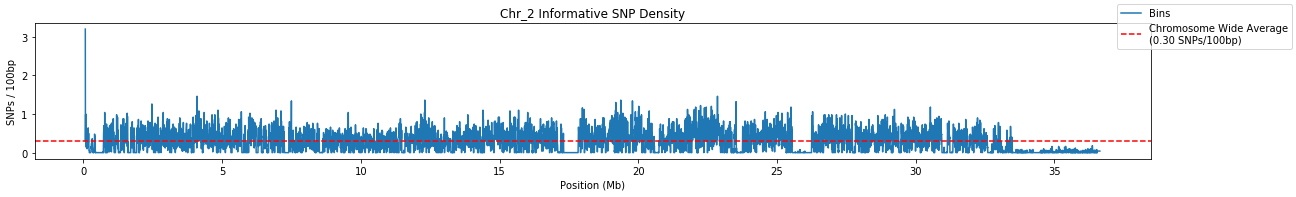

Chr_3: SNP every 398.46 bp; 9970.05 bp standard deviation in density (70532 total SNPs)


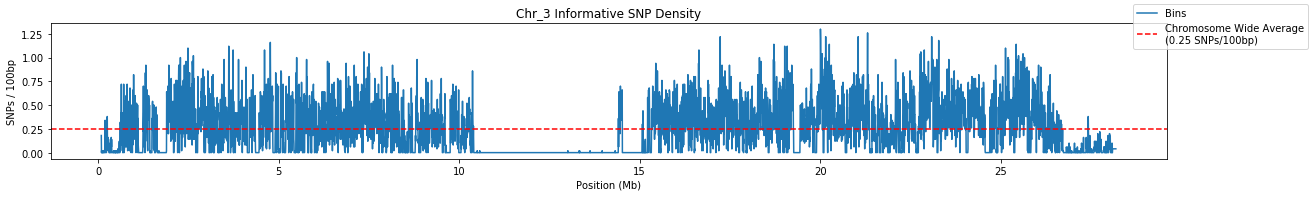

Chr_4: SNP every 278.33 bp; 2173.87 bp standard deviation in density (104684 total SNPs)


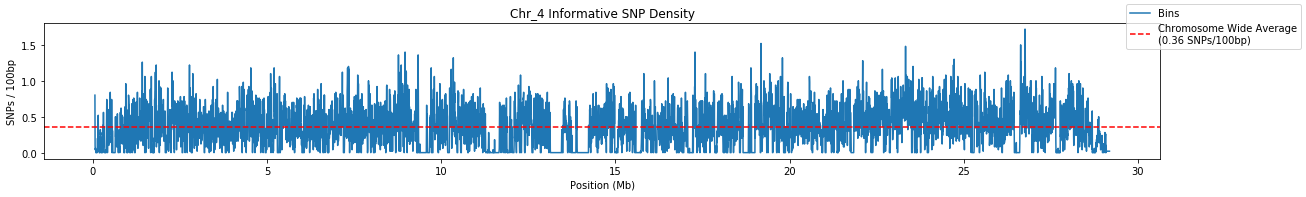

Chr_5: SNP every 348.02 bp; 4715.35 bp standard deviation in density (79531 total SNPs)


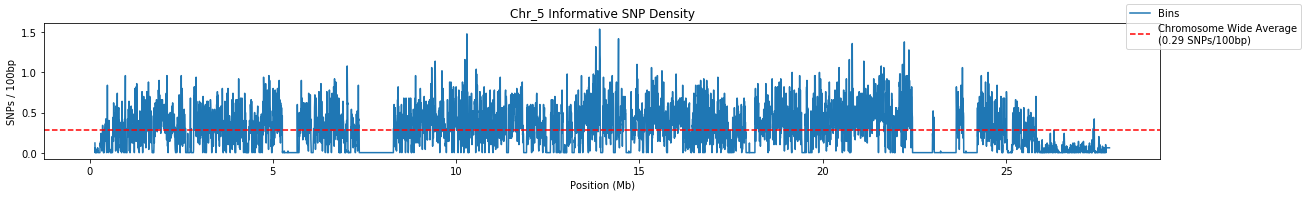

Chr_X: SNP every 2764.13 bp; 7451.73 bp standard deviation in density (11020 total SNPs)


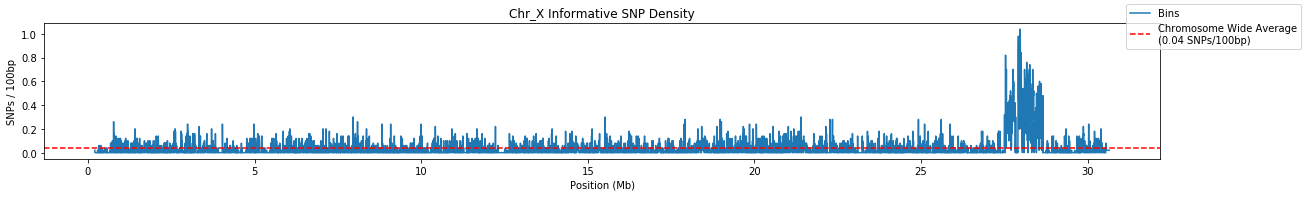

In [26]:
snp_density(input_file='/home/iskander/Documents/Barbash_lab/mDrive/REF/vir48_vir47.npy', binsize=100000, ref='vir48, vir47')

-----------------------------------------------

In [68]:
ref = np.load('/home/iskander/Documents/Barbash_lab/mDrive/REF/dvir47_dvir51.v2.snp_reference.npy', allow_pickle=True)

In [40]:
def load_reference(reference, path):
    np_file = os.path.join(path, reference)
    reference = np.load(np_file, allow_pickle=True)
    return reference

def snp_density(input_file, ref='Dvir47_Dvir48', binsize=5000):
    #Doing some rudimentary analysis on number of informative SNPs per chromosome in a particular comparison
    chromosomes = ('Chr_2', 'Chr_3', 'Chr_4', 'Chr_5', 'Chr_X')
    reference_snps = load_reference(path='/home/iskander/Documents/Barbash_lab/mDrive/REF/', reference=input_file)
    print(ref)
    for scaffolds in range(len(chromosomes)):#Generate some rough summary statistics
        num_snps = len(reference_snps[scaffolds][:,0])
        scaffold_snps = reference_snps[scaffolds]
        snp_holder = [0 for x in range(num_snps)]
        dist_snps = []
        for snp in range(1, len(scaffold_snps)):#average distance between SNPs
            diff = scaffold_snps[snp][0] - scaffold_snps[snp-1][0]
            dist_snps.append(diff)
        avg_dist = np.average(dist_snps)
        var_dist = np.var(dist_snps)
        
        
        print('{0}: SNP every {1:.2f} bp; {3:.2f} bp standard deviation in density ({2} total SNPs)'.format(chromosomes[scaffolds], avg_dist, num_snps, var_dist**(1/2)))
        
#Let's window across the chromosome arm and calculate the SNP density in say 5kb bins to plot the density better
        
        snp_list = []
        bin_list = []
        snp_positions = scaffold_snps[:,0]
        for bins in range(scaffold_snps[0][0], scaffold_snps[-1][0]-4999, 5000): 
            bin_list.append((bins+(binsize/2))/ 1000000)
            snp_count = 0 
            for position in range(len(snp_positions)):
                if snp_positions[position] >= bins and snp_positions[position] <= bins+binsize:
                    snp_count += 1
                elif snp_positions[position] > bins+binsize:
                    snp_positions = snp_positions[position:]
                    break
            snp_list.append(snp_count*(.02))#Get SNPs per 100bps
        avg = np.average(snp_list)
        legends = ['Bins', 'Chromosome Wide Average\n({0:.2f} SNPs/100bp)'.format(avg)]
        plt.figure(figsize=(20,2.5))
        plt.title('{0} Informative SNP Density'.format(chromosomes[scaffolds]))
        plt.ylabel('SNPs / 100bp')
        plt.xlabel('Position (Mb)')
        sns.lineplot(bin_list, snp_list)
        plt.axhline(avg, linestyle='--', color='red')
        plt.figlegend(legends)
        plt.show()

## Sequence diversity:

I windowed $\pi$ in windows for our individuals so I can observe regions of high diversity and to see the over all patterns of diversity.

In [34]:
pi = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/virillis/VCF/out.windowed.pi', sep='\t')
pi

,CHROM,BIN_START,BIN_END,N_VARIANTS,PI
0,Chr_2,1,200000,1587,2.215580e-03
1,Chr_2,200001,400000,1142,1.550280e-03
2,Chr_2,400001,600000,1592,1.922290e-03
3,Chr_2,600001,800000,1274,1.624740e-03
4,Chr_2,800001,1000000,3191,4.213870e-03
5,Chr_2,1000001,1200000,3785,4.484180e-03
6,Chr_2,1200001,1400000,3367,4.109250e-03
7,Chr_2,1400001,1600000,4384,4.902970e-03
8,Chr_2,1600001,1800000,2484,2.902750e-03
9,Chr_2,1800001,2000000,2922,3.338810e-03


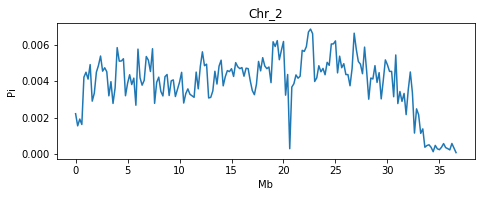

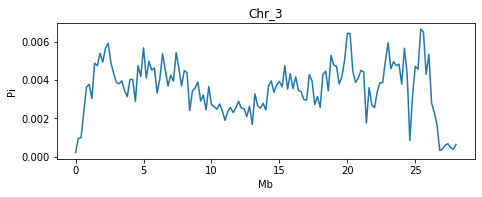

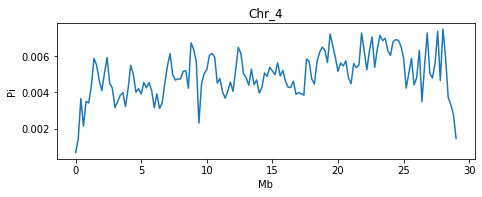

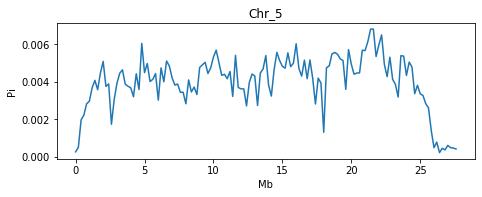

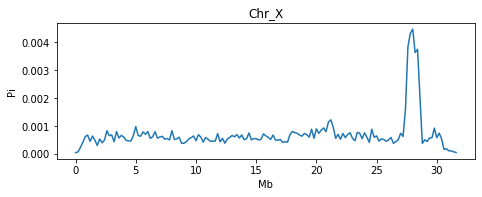

In [35]:
for scaffold in ['Chr_2', 'Chr_3', 'Chr_4', 'Chr_5', 'Chr_X']:
    chrom_data  = pi.loc[pi['CHROM']==scaffold].values
    
    fig = plt.figure(figsize=(7.5,2.5))
    plt.plot(chrom_data[:,1]/1000000, chrom_data[:,4])
    plt.xlabel('Mb')
    plt.ylabel('Pi')
    plt.title(scaffold)
    plt.show()
    plt.close()

So sequence diversity in these windows actually seems pretty low honestly. I think that this may be a faily bad sign. The bin size is a bit too small I think as it looks very spikey. 

Let's compare this data to the DGRP and see.

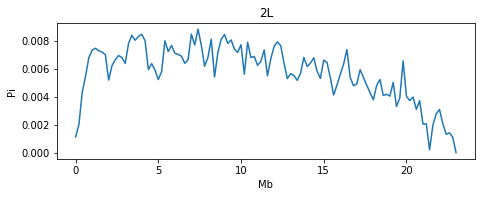

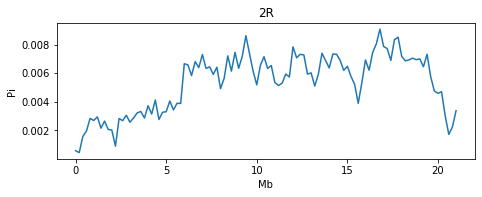

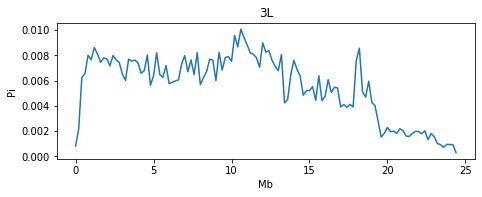

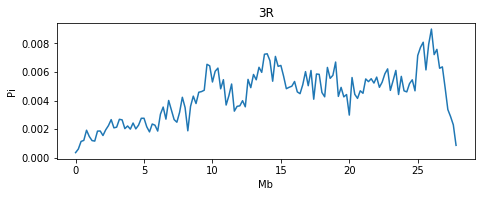

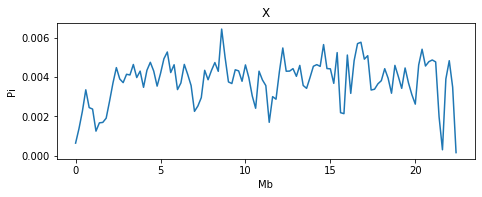

In [39]:
dmelpi = pd.read_csv('/home/iskander/Documents/MEIOTIC_DRIVE/out.windowed.pi', sep='\t')
for scaffold in ['2L', '2R', '3L', '3R', 'X']:
    chrom_data  = dmelpi.loc[dmelpi['CHROM']==scaffold].values
    
    fig = plt.figure(figsize=(7.5,2.5))
    plt.plot(chrom_data[:,1]/1000000, chrom_data[:,4])
    plt.xlabel('Mb')
    plt.ylabel('Pi')
    plt.title(scaffold)
    plt.show()
    plt.close()

So actually it isnt that much different. And I think that some differences are probably can be attributed to the much lower sequencing depth on virillis libraries. Having said that the X in virillis has very low sequence diversity. 

## SNP density:

I will examine the density of SNPs in 200kb bins to see the over all trends of SNPs.

In [16]:
snpden = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/virillis/STATS/Dvir.GATK_calls_8-24.snpden', sep='\t')
snpden

,CHROM,BIN_START,SNP_COUNT,VARIANTS/KB
0,Chr_2,0,1798,8.990
1,Chr_2,200000,1308,6.540
2,Chr_2,400000,1990,9.950
3,Chr_2,600000,1505,7.525
4,Chr_2,800000,3744,18.720
5,Chr_2,1000000,4605,23.025
6,Chr_2,1200000,4210,21.050
7,Chr_2,1400000,5306,26.530
8,Chr_2,1600000,3049,15.245
9,Chr_2,1800000,3682,18.410


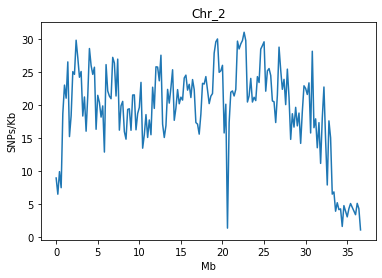

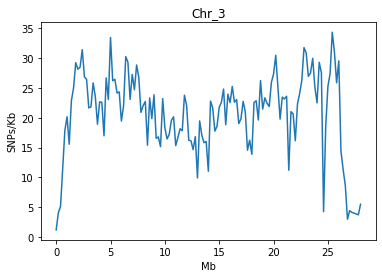

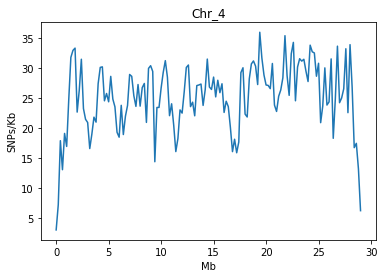

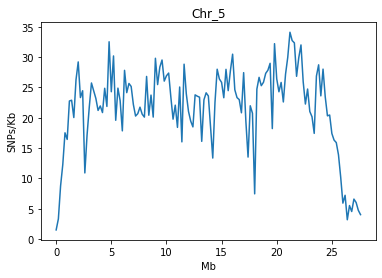

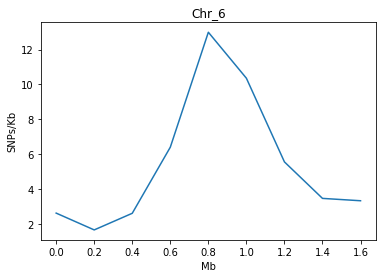

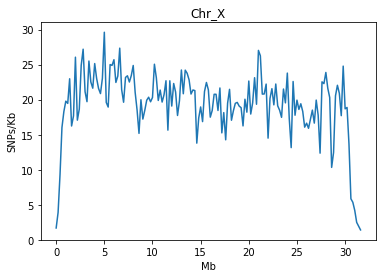

In [21]:
for scaffold in ['Chr_2', 'Chr_3', 'Chr_4', 'Chr_5', 'Chr_6', 'Chr_X']:
    
    chrom_data  = snpden.loc[snpden['CHROM']==scaffold].values
    plt.plot(chrom_data[:,1]/1000000, chrom_data[:,3])
    plt.xlabel('Mb')
    plt.ylabel('SNPs/Kb')
    plt.title(scaffold)
    plt.show()
    plt.close()

The SNP density seems to be very high which would be good if we had higher sequence diversity.

# Acessible Chromatin:

For the D virillis experiments I have no real idea what regions of the genome would be acessible. The most reasonable thing to do would be to use the ATAC peaks from the Melanogaster stuff and map them roughly by synteny. 

# Recombination map:

So, since I don't have a recombination map for virillis, and I kind of need one I will either have to make something up or continue to simulate off of melanogaster maps.